In [1]:
from sqlalchemy import create_engine
from sqlalchemy.orm import sessionmaker
sqlite_path = f"../content_scraper_0.1.0.sqlite3"
engine = create_engine(
    f"sqlite:///{sqlite_path}",
    connect_args={"check_same_thread": False},
)
def get_session():
    """Returns a new session object the current engine

    :return: sqlalchemy Session
    :rtype: session

    """
    Session = sessionmaker(bind=engine)
    return Session()

In [2]:
import content_scraper.db as db
import content_scraper.db.models as models
import preprocessor as p
import pandas as pd
import matplotlib.pyplot as plt
from sentence_transformers import SentenceTransformer
import numpy as np

In [3]:
show = True

In [4]:
p.set_options(p.OPT.URL, p.OPT.EMOJI, p.OPT.MENTION)

In [5]:
session = get_session()
TextContentsMetadatas = session.query(models.TextContent, models.TextMetadata)\
            .join(models.TextMetadata)\
            .distinct(models.TextContent.content)\
            .group_by(models.TextContent.content)\
            .all()

original_tweets = [_[0].content for _ in TextContentsMetadatas]
clean_tweets = [p.clean(_[0].content) for _ in TextContentsMetadatas]
native_ids = [_[1].native_id for _ in TextContentsMetadatas]
publication_dates = [_[1].publication_date for _ in TextContentsMetadatas]
authors = [session.query(models.TextAuthor).filter(models.TextAuthor.id == _[1].author).first().username for _ in TextContentsMetadatas]
conversation_native_id = [_[1].conversation_native_id for _ in TextContentsMetadatas]

session.close()

In [6]:
df = pd.DataFrame({"tweets": clean_tweets, "originals":original_tweets, "native_ids":native_ids, "publication_dates":publication_dates, "authors":authors, "conversation_native_id":conversation_native_id})
tweet_lengths = df.tweets.apply(lambda x: len(x.split(" ")))
df["tweet_lengths"] = tweet_lengths

In [7]:
df.head()

,tweets,originals,native_ids,publication_dates,authors,conversation_native_id,tweet_lengths
0,"I don't like doing this, but make sure to repo...",https://t.co/BXh4r53C8k I don't like doing th...,1301506689246662656,2020-09-03 09:05:50,yegortf2,1301506689246662656,15
1,he gets his sons free after one raped and almo...,https://t.co/U40eJ5qQFP he gets his sons free...,1311039330597527552,2020-09-29 16:25:09,josevarney,1311039330597527552,44
2,FLORIDA SEX ADDICT COP BUSTED 4 SELLING CHILD ...,https://t.co/qEUsqxPdi3 FLORIDA SEX ADDICT C...,1168504021465915394,2019-09-02 08:40:43,policest8,1168504021465915394,23
3,if you have to apologize for selling child por...,https://t.co/xv7OXz0GeR if you have to apolog...,1304141432463253504,2020-09-10 15:35:21,ncdeplorables,1304141432463253504,25
4,"""Man Was Selling Child Porn on Twitter Using C...","""Man Was Selling Child Porn on Twitter Using C...",1349250767673286656,2021-01-13 02:03:45,jermdine,1349250767673286656,31


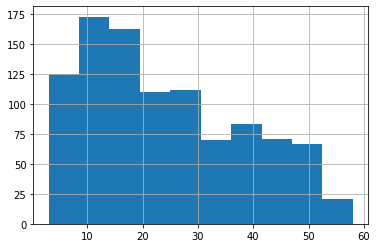

In [8]:
df.tweet_lengths.hist()

In [9]:
df = df[df.tweet_lengths >= 20].copy()

In [10]:
model = SentenceTransformer("bert-base-nli-stsb-mean-tokens")

In [11]:
df['tweet_vecs'] = model.encode(df.tweets.tolist()).tolist()

In [12]:
df

,tweets,originals,native_ids,publication_dates,authors,conversation_native_id,tweet_lengths,tweet_vecs
1,he gets his sons free after one raped and almo...,https://t.co/U40eJ5qQFP he gets his sons free...,1311039330597527552,2020-09-29 16:25:09,josevarney,1311039330597527552,44,"[-0.44001656770706177, -0.1619897037744522, 1...."
2,FLORIDA SEX ADDICT COP BUSTED 4 SELLING CHILD ...,https://t.co/qEUsqxPdi3 FLORIDA SEX ADDICT C...,1168504021465915394,2019-09-02 08:40:43,policest8,1168504021465915394,23,"[0.08328109979629517, -0.4180629849433899, -0...."
3,if you have to apologize for selling child por...,https://t.co/xv7OXz0GeR if you have to apolog...,1304141432463253504,2020-09-10 15:35:21,ncdeplorables,1304141432463253504,25,"[0.5873322486877441, 0.4817993938922882, 0.244..."
4,"""Man Was Selling Child Porn on Twitter Using C...","""Man Was Selling Child Porn on Twitter Using C...",1349250767673286656,2021-01-13 02:03:45,jermdine,1349250767673286656,31,"[0.26980289816856384, 0.18446354568004608, -0...."
6,#BigTechAccountability? Why did THIS take so l...,#BigTechAccountability? Why did THIS take so ...,1349682356274286593,2021-01-14 06:38:44,lynnshawprod,1349682356274286593,22,"[0.2488568276166916, -0.02332328073680401, -0...."
...,...,...,...,...,...,...,...,...
987,", ? ? Why any mainstream media not puts a spec...","कहाँ से आते है इतने सारे बलात्कारी, कोन्से समा...",1328726227444613120,2020-11-17 10:46:33,withdarkx,1328726227444613120,37,"[0.5476198196411133, 0.032762616872787476, 0.3..."
988,Kittiphong the man arrested for selling child ...,‘Kittiphong’ the man arrested for selling chil...,1266397235757174784,2020-05-29 11:53:24,thaimythbuster,1266397235757174784,49,"[0.1553393453359604, 0.2500622868537903, -0.34..."
989,Mindgeek is a private company run from Montrea...,‘Mindgeek is a private company run from Montre...,1335288487684161537,2020-12-05 13:22:38,arhiandavies,1335288487684161537,35,"[0.6383651494979858, -0.08805650472640991, -0...."
990,depicted a 3 year old saying she wont put my p...,⁦@gabcake⁩ depicted a 3 year old saying she “w...,1334402219073024000,2020-12-03 02:40:55,mimi___kaa,1334402219073024000,30,"[0.1318182349205017, 0.1298377960920334, -0.04..."


In [13]:
def cos_distance(a, b):
    a_dot_b = np.dot(a,b)
    mag_a_mag_b = np.linalg.norm(a) * np.linalg.norm(b)
    return (a_dot_b / mag_a_mag_b)

def calc_distances(df_x, target_row):
  print(f'Looking for texts close to [{df_x.tweets.iloc[target_row]}]')
  body_vecs = df_x.body_vec.tolist()
  distances = list()
  for i in range(0, len(body_vecs)):
    dist = cos_distance(tweet_vecs[i], tweet_vecs[target_row])
    distances.append(dist)

  df_x['distances'] = distances
  df_x.distances.hist()
  return(df_x)

In [14]:
search_string = df.tweets.iloc[0]
similarity_threshold = 0.5
rows = 50

vectorized_input = model.encode([search_string])[0]

def find_similar_strings(df_a, query_vec, threshold=similarity_threshold, target_column='tweet_vecs'):
  body_vecs = df_a[target_column].tolist()
  distances = []
  for i in range(0, len(body_vecs)):
    dist = cos_distance(body_vecs[i], query_vec)
    distances.append(dist)

  df_a['similarity'] = distances
  df_a = df_a.sort_values(by=['similarity'], ascending=False)
  df_a = df_a[df_a['similarity'] > threshold]
  return (df_a)

df_closest_matches = find_similar_strings(df.copy(), vectorized_input, similarity_threshold)
df_closest_matches[['tweets', 'similarity']].head(n=rows)

,tweets,similarity
1,he gets his sons free after one raped and almo...,1.000000
725,Man Was Selling Child Porn on Twitter Using Co...,0.768522
627,Do you know how much I bawled my eyes out when...,0.726323
147,Reminds me of a guy that re-ended me. After th...,0.721700
161,year ago he was selling child porn behind payw...,0.720458
162,But considering the above scene it kind of mak...,0.709621
975,the reason that is cus he had a family to hand...,0.702273
386,Selling child porn doesnt mean u have to get b...,0.693060
716,Jurors want to know why a man wd rape a child....,0.691750
535,"dont tag Rob in this, it will go over his head...",0.685441


In [15]:
if False:
   df_closest_matches[['tweets', 'similarity']].to_csv("query_results.csv")

## Topics

In [16]:
from sklearn.cluster import KMeans

all_body_vecs = np.asarray(df.tweet_vecs.tolist())
kmeans = KMeans(n_clusters=20, random_state=0).fit(all_body_vecs)

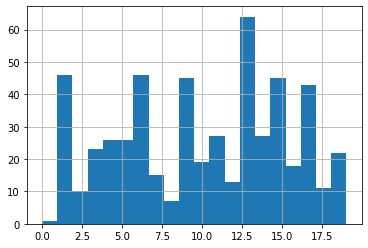

In [17]:
cluster_labels = kmeans.predict(all_body_vecs)
df['label'] = cluster_labels
df.label.hist(bins=20)

In [18]:
label = 13

In [19]:
df[df.label==label].shape

(64, 9)

In [20]:
from IPython.display import display
display(df[df.label==label][['tweets']].head(n=20).style.set_properties(**{
        'width': '1000px',
        'max-width': '1000px'
    }))

,tweets
37,"Selling child porn isnt therapy. Even if this person is a CSA survivor, which there is no evidence of whatsoever, actively encouraging unknown adults to view children as sex objects and making money off that isnt therapy. Its perpetuating the cycle of abuse."
49,"I think what you call unlawful behavior, we call freedom in the context of drugs sounds very wrong, and reinforces the I believe in BTC because my idea of freedom is selling child porn on the deep web stereotype. Wrong way to convey ur message imo but the first 2 lines are ok"
50,does she think saying she realized she was detached from reality will give her an insanity defense if she's charged w/selling child porn? There's no way she didn't understand what she was doing
53,Here is another one.....That is two on twitter posting and selling child porn. Weird how twitter can censor lawful Americans but can't police themselves on child porn.
56,"With their logic, selling child porn, if it stimulated the economy, would be ok? Just because something generates money or stimulates the economy does not make it O or excuse bad behavior. Unless, of course, you only care about money."
64,"Some people, especially the young and depressed, are highly susceptible to being influenced. Sure you and I know pedophilia and nazis are wrong, but if someone that is lost in life and depressed or just inexperienced sees people selling child porn, or very close to child porn 1/2"
74,"If it's for her past behavior of selling child porn, then good. To hell with her for that. If it's not, then... Why not? And why are people who've posted more sexually explicit stuff than her still on there? Ban for the right reasons, youtube."
86,"You can't answer a question with a simple yes or no if the premise of the question is ludicrous. If you did answer with a y/n, you probably committed perjury. What if you were asked ""are you sorry for selling child porn? YES OR NO!"""
87,"Not her when underage. thats a failure on her parents if shes selling child porn. That pedo geared shit on pornhub is gross too. Like why is anyone making shit that appeals to pedophiles, is the market actually that big?"
105,why are we more worried about masked and not worried about selling child porn on their platform? #ChildTrafficking is in the rise no?


In [28]:
df[df.label==label].loc[53].originals

"@Breaking911 Here is another one.....That is two on twitter posting and selling child porn.  Weird how twitter can censor lawful Americans but can't police themselves on child porn.  https://t.co/oY6za13Hmg"